Build a spam classifier (a more challenging exercise):  
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.  
• Unzip the datasets and familiarize yourself with the data format.  
• Split the datasets into a training set and a test set.  
• Write a data preparation pipeline to convert each email into a feature vector.  

Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.   

You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
  
Finally, try out several classifiers and see if you can build a great spam classi
fier, with both high recall and high precision.

### Download the Dataset

In [13]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset = 'abdmental01/email-spam-dedection'
download_path = './datasets'

api.dataset_download_files(dataset, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/abdmental01/email-spam-dedection


### Load Dataset

In [71]:
import os
import pandas as pd

filename = "mail_data.csv"
download_path = './datasets'

emails = pd.read_csv(os.path.join(download_path, filename))

### Basic Information

In [72]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [73]:
emails.sample(5)

,Category,Message
3565,ham,Do you always celebrate NY's with your family ?
3061,ham,K..k...from tomorrow onwards started ah?
832,ham,Hi mate its RV did u hav a nice hol just a mes...
4315,ham,Is ur changes 2 da report big? Cos i've alread...
3545,ham,Lol ok ill try to send. Be warned Sprint is de...


In [74]:
emails[emails["Category"] == "spam"]

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [75]:
emails.rename(columns={'Category': 'Spam'}, inplace=True)
emails["Spam"] = emails["Spam"].replace({'spam': 1, 'ham': 0})

C:\Users\adars\AppData\Local\Temp\ipykernel_13552\2718226212.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emails["Spam"] = emails["Spam"].replace({'spam': 1, 'ham': 0})


In [76]:
emails

,Spam,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Train/Test Split

In [77]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(emails, test_size=0.20, random_state=42)
print(train_set.shape)
print(test_set.shape)

(4457, 2)
(1115, 2)


### EDA

([<matplotlib.axis.YTick at 0x19518616350>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

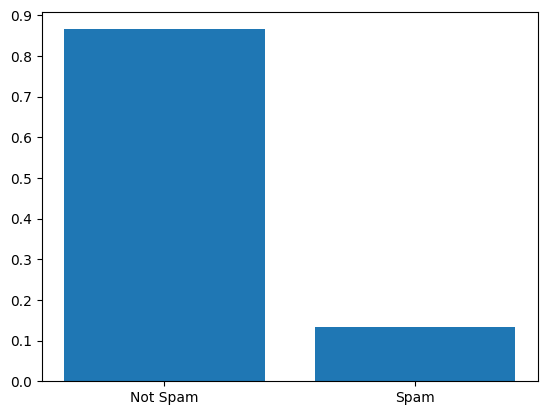

In [78]:
import matplotlib.pyplot as plt
import numpy as np

counts = emails['Spam'].value_counts()
plt.bar(counts.index, counts.values/sum(counts))
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.yticks(np.arange(0, 1, 0.1))

### Prepare data for ML algorithm 

In [79]:
X = train_set.drop("Spam", axis=1)
y = train_set["Spam"].copy()

In [89]:
X.loc[0]["Message"]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Custom transformers for various purposes

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
import re

class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True):
        self.lowercase = lowercase

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.lowercase:
            return [text.lower() for text in X]
        else:
            return X

class NumberReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, keep_numbers=None):
        self.keep_numbers = keep_numbers
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess_numbers(text) for text in X]
    
    def _preprocess_numbers(self, text):
        if self.keep_numbers:
            keep_pattern = '|'.join(map(str, self.keep_numbers))
            pattern = r'\b(?!(' + keep_pattern + r')\b)\d+\b'
        else:
            pattern = r'\b\d+\b'

        text = re.sub(pattern, 'NUMBER', text)

        return text
    
class URLReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace=True):
        self.replace = replace
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.replace:
            url_pattern = r'https?://\S+|www\.\S+'
            return [re.sub(url_pattern, 'URL', text) for text in X]
        else:
            return X
    
class PunctuationReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace=True):
        self.replace=replace

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.replace:
            punctuation_pattern = r'[^\w\s]'
            return [re.sub(punctuation_pattern, '', text) for text in X]
        else:
            return X
        
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stem=True):
        self.stem = stem
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.stem:
            return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]
        else:
            return X